In [1]:
import os

# --- ESTABLECIMIENTO DEL PUNTO DE ORIGEN ---
# Definimos la ruta absoluta del usuario en el contenedor. 
# Esto evita que el código se "pierda" si ejecutas la celda varias veces.
HOME_DIR = "/home/jovyan"

# Forzamos al sistema a situarse en esta carpeta.
# Es como decirle al explorador de archivos: "Vuelve siempre a la carpeta principal".
os.chdir(HOME_DIR)

print(f"✅ Directorio fijado en: {os.getcwd()}")

# --- DEFINICIÓN DE LA ESTRUCTURA DE PROYECTO ---
# Usamos os.path.join para construir rutas de forma segura.
# Esto asegura que las barras (/) funcionen correctamente en cualquier sistema operativo.

# 1. Donde están los archivos .tif originales (entrada)
RAW_DIR = os.path.join(HOME_DIR, "data/raw")

# 2. Donde se guardarán los índices calculados (GeoTIFFs procesados)
PROCESSED_DIR = os.path.join(HOME_DIR, "data/processed")

# 3. Donde se guardarán los mapas finales y gráficos para el informe (PNGs)
FIGURES_DIR = os.path.join(HOME_DIR, "outputs/figures")

# Verificación visual para el usuario
print(f"Ruta para datos: {RAW_DIR}")

✅ Directorio fijado en: /home/jovyan
Ruta para datos: /home/jovyan/data/raw


In [2]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE RUTAS Y DIRECTORIOS ---
# Definimos dónde están los datos de entrada y dónde guardaremos los resultados
RAW_DIR = "data/raw"              # TIFs originales bajados de Earth Engine
OUT_RASTER_DIR = "data/processed" # Para guardar los índices calculados en formato .tif
OUT_FIG_DIR = "outputs/figures"   # Para guardar los mapas visuales en formato .png

# Creamos las carpetas de salida si no existen para evitar errores
os.makedirs(OUT_RASTER_DIR, exist_ok=True)
os.makedirs(OUT_FIG_DIR, exist_ok=True)

# Lista de años que queremos procesar (deben coincidir con los nombres de archivo)
years = [2017, 2019, 2021, 2024]

# Función auxiliar para evitar errores matemáticos de "división por cero"
# Si b es 0, devuelve NaN (Not a Number), evitando que el script se detenga
def safe_divide(a, b):
    return np.where(b == 0, np.nan, a / b)

# --- PROCESAMIENTO POR AÑO ---
for year in years:
    # Construimos la ruta del archivo original
    path = os.path.join(RAW_DIR, f"sentinel2_pudahuel_{year}.tif")
    
    # Verificamos si el archivo existe antes de intentar abrirlo
    if not os.path.exists(path):
        print(f"Archivo no encontrado para {year}, se omite.")
        continue

    print(f"Procesando {year}...")

    # Abrimos el archivo Raster usando Rasterio
    with rasterio.open(path) as src:
        # Leemos cada banda y la convertimos a float32 para cálculos decimales precisos
        blue  = src.read(1).astype("float32")   # Banda 2 (Azul)
        green = src.read(2).astype("float32")   # Banda 3 (Verde)
        red   = src.read(3).astype("float32")   # Banda 4 (Rojo)
        nir   = src.read(4).astype("float32")   # Banda 8 (Infrarrojo cercano)
        swir1 = src.read(5).astype("float32")   # Banda 11 (Infrarrojo de onda corta 1)
        swir2 = src.read(6).astype("float32")   # Banda 12 (Infrarrojo de onda corta 2)

        # Copiamos los metadatos del original (proyección, coordenadas)
        # Actualizamos para que el archivo de salida sea de 1 sola banda y tipo float32
        meta = src.meta.copy()
        meta.update(count=1, dtype="float32")

    # --- CÁLCULO DE ÍNDICES ESPECTRALES ---
    # NDVI: Identifica vegetación (valores altos = más verde)
    ndvi = safe_divide(nir - red, nir + red)
    
    # NDBI: Identifica áreas urbanas/construidas (valores altos = más cemento)
    ndbi = safe_divide(swir1 - nir, swir1 + nir)
    
    # NDWI: Identifica cuerpos de agua o humedad
    ndwi = safe_divide(green - nir, green + nir)
    
    # BSI: Índice de Suelo Desnudo (útil para ver expansión urbana o erosión)
    bsi  = safe_divide((swir1 + red) - (nir + blue),
                       (swir1 + red) + (nir + blue))

    # Diccionario para iterar y guardar cada índice fácilmente
    indices = {
        "NDVI": ndvi,
        "NDBI": ndbi,
        "NDWI": ndwi,
        "BSI":  bsi
    }

    # --- GUARDADO DE RESULTADOS ---
    for name, data in indices.items():
        # 1. Guardar como archivo GeoTIFF (para análisis espacial posterior en GIS)
        raster_out = os.path.join(
            OUT_RASTER_DIR, f"{name.lower()}_pudahuel_{year}.tif"
        )
        with rasterio.open(raster_out, "w", **meta) as dst:
            dst.write(data, 1)

        # 2. Generar y guardar un mapa visual (Imagen PNG)
        plt.figure(figsize=(6, 5))
        plt.imshow(data, cmap="RdYlGn") # Escala de colores Rojo-Amarillo-Verde
        plt.colorbar(label=name)
        plt.title(f"{name} - Pudahuel {year}")
        plt.axis("off") # Quitar coordenadas de los ejes para que se vea limpio

        fig_out = os.path.join(
            OUT_FIG_DIR, f"{name.lower()}_pudahuel_{year}.png"
        )
        plt.savefig(fig_out, dpi=200, bbox_inches="tight")
        plt.close() # Cerrar la figura para liberar memoria RAM

    print(f"Índices calculados para {year}")

print("Proceso finalizado.")

Procesando 2017...
Índices calculados para 2017
Procesando 2019...
Índices calculados para 2019
Procesando 2021...
Índices calculados para 2021
Procesando 2024...
Índices calculados para 2024
Proceso finalizado.


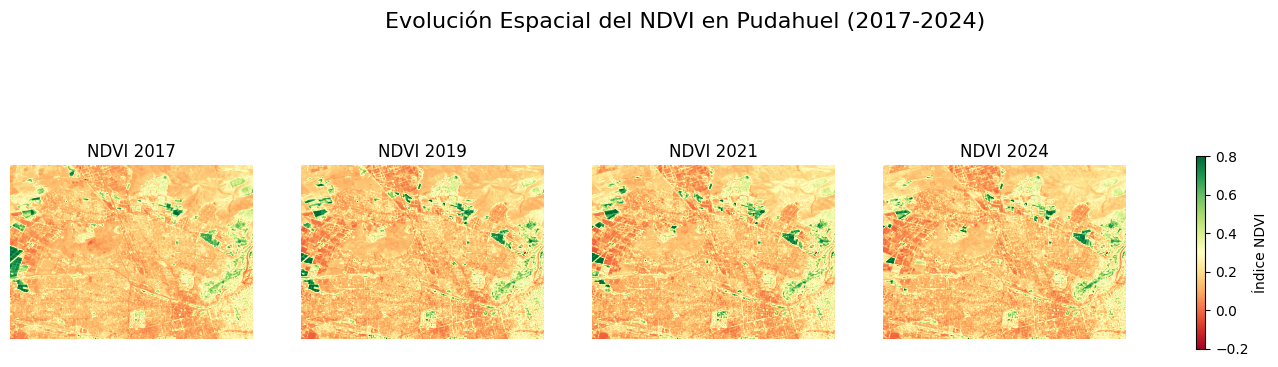

📊 RESULTADOS DEL ANÁLISIS:
Pérdida de vegetación: 2.33%
Nuevas construcciones: 2.70%
Cambio Urbano Crítico: 1.61%


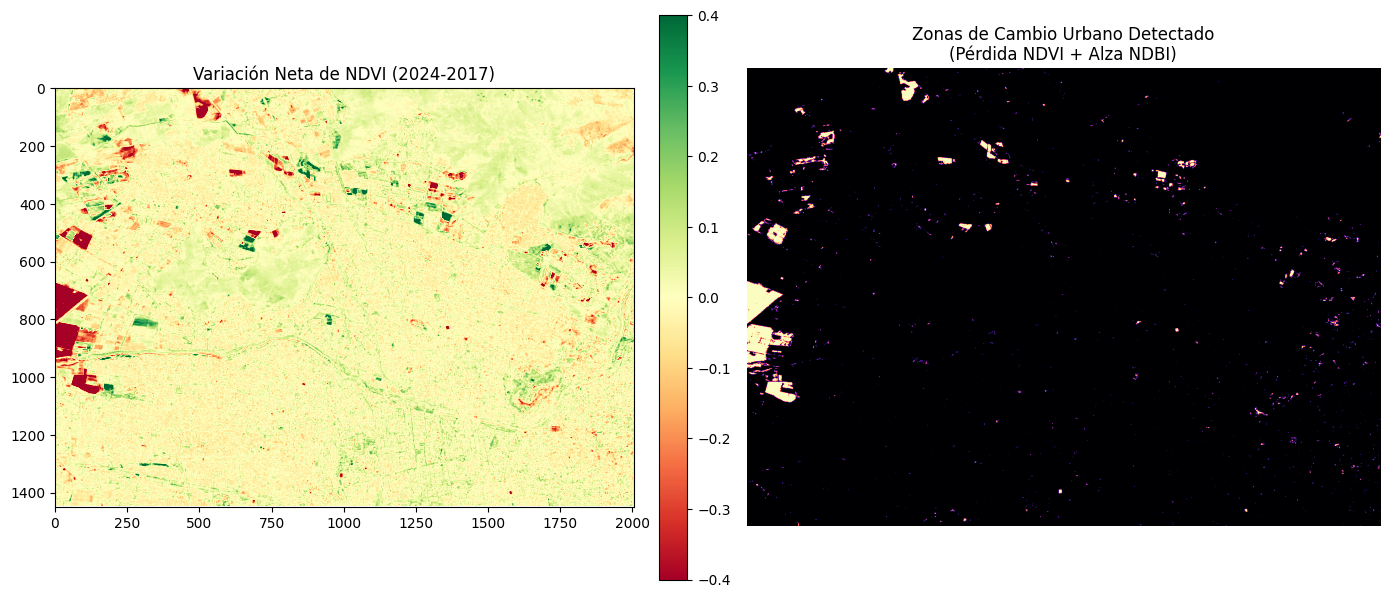


--- RESUMEN ESTADÍSTICO ---
 Año  Media NDVI  Máximo NDVI  Desviación
2017    0.184632     1.000000    0.136641
2019    0.183654     0.910230    0.152566
2021    0.187591     0.951327    0.153449
2024    0.182532     0.903477    0.145649


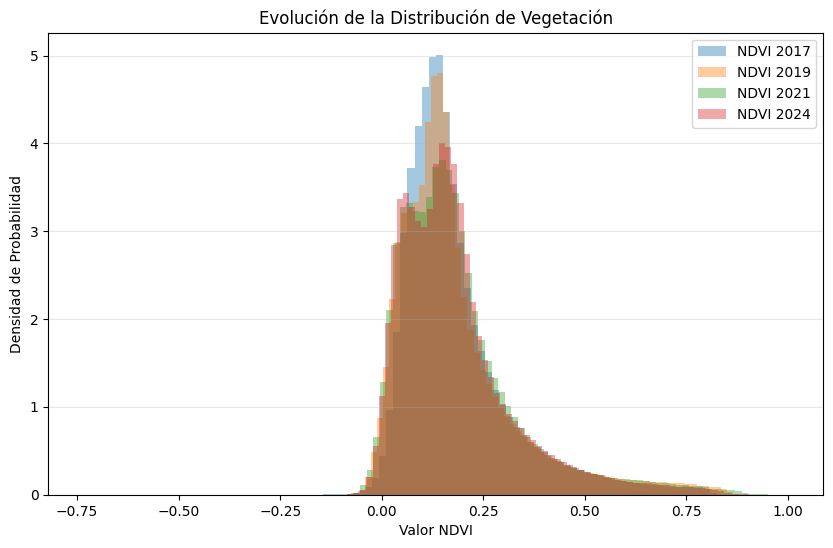

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---
IN_DIR = "data/processed"
OUT_DIR = "outputs/figures"
os.makedirs(OUT_DIR, exist_ok=True)
years = [2017, 2019, 2021, 2024]

# Diccionarios para almacenar datos en memoria y evitar re-lecturas
data_ndvi = {}
data_ndbi = {}
meta_sample = None

for year in years:
    with rasterio.open(os.path.join(IN_DIR, f"ndvi_pudahuel_{year}.tif")) as src:
        data_ndvi[year] = src.read(1)
        if year == 2017: meta_sample = src.meta.copy() # Guardamos meta para exportar luego
    with rasterio.open(os.path.join(IN_DIR, f"ndbi_pudahuel_{year}.tif")) as src:
        data_ndbi[year] = src.read(1)

# --- 2. ANÁLISIS MULTITEMPORAL (Subplots) ---
fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
for i, year in enumerate(years):
    im = axes[i].imshow(data_ndvi[year], cmap="RdYlGn", vmin=-0.2, vmax=0.8)
    axes[i].set_title(f"NDVI {year}", fontsize=12)
    axes[i].axis("off")

fig.colorbar(im, ax=axes, shrink=0.5, label="Índice NDVI")
plt.suptitle("Evolución Espacial del NDVI en Pudahuel (2017-2024)", fontsize=16)
plt.savefig(f"{OUT_DIR}/ndvi_comparativo_grid.png", dpi=200, bbox_inches="tight")
plt.show()

# --- 3. CÁLCULO DE DIFERENCIAS Y ESTADÍSTICAS ---
delta_ndvi = data_ndvi[2024] - data_ndvi[2017]
delta_ndbi = data_ndbi[2024] - data_ndbi[2017]

# Máscara de valores válidos (para evitar NaNs en cálculos)
valid_mask = np.isfinite(delta_ndvi) & np.isfinite(delta_ndbi)
total_valid_pixels = valid_mask.sum()

# Umbrales para detección de cambios
ndvi_loss = (delta_ndvi < -0.2) & valid_mask
ndbi_gain = (delta_ndbi > 0.2) & valid_mask
cambio_urbano = ndvi_loss & ndbi_gain # Intersección: perdió verde Y ganó cemento

print(f"📊 RESULTADOS DEL ANÁLISIS:")
print(f"Pérdida de vegetación: {(ndvi_loss.sum()/total_valid_pixels)*100:.2f}%")
print(f"Nuevas construcciones: {(ndbi_gain.sum()/total_valid_pixels)*100:.2f}%")
print(f"Cambio Urbano Crítico: {(cambio_urbano.sum()/total_valid_pixels)*100:.2f}%")

# --- 4. VISUALIZACIÓN DE CAMBIOS CRÍTICOS ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Mapa de calor de pérdida/ganancia NDVI
im1 = ax[0].imshow(delta_ndvi, cmap="RdYlGn", vmin=-0.4, vmax=0.4)
ax[0].set_title("Variación Neta de NDVI (2024-2017)")
plt.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)

# Mapa binario de cambio urbano
ax[1].imshow(cambio_urbano, cmap="magma")
ax[1].set_title("Zonas de Cambio Urbano Detectado\n(Pérdida NDVI + Alza NDBI)")
ax[1].axis("off")

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/deteccion_cambios_criticos.png", dpi=200)
plt.show()

# --- 5. HISTOGRAMAS Y TABLA ESTADÍSTICA ---
stats_list = []
plt.figure(figsize=(10, 6))

for year in years:
    clean_val = data_ndvi[year][np.isfinite(data_ndvi[year])]
    stats_list.append({
        "Año": year,
        "Media NDVI": np.mean(clean_val),
        "Máximo NDVI": np.max(clean_val),
        "Desviación": np.std(clean_val)
    })
    plt.hist(clean_val, bins=100, alpha=0.4, label=f"NDVI {year}", density=True)

plt.title("Evolución de la Distribución de Vegetación")
plt.xlabel("Valor NDVI")
plt.ylabel("Densidad de Probabilidad")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"{OUT_DIR}/histograma_evolucion.png")

df_stats = pd.DataFrame(stats_list)
print("\n--- RESUMEN ESTADÍSTICO ---")
print(df_stats.to_string(index=False))

# --- 6. EXPORTACIÓN DE RASTERS DE CAMBIO ---
meta_sample.update(dtype="float32", count=1)
outputs = {
    "delta_ndvi_2017_2024.tif": delta_ndvi,
    "delta_ndbi_2017_2024.tif": delta_ndbi,
    "cambio_urbano_binario.tif": cambio_urbano.astype("float32")
}

for filename, array in outputs.items():
    with rasterio.open(os.path.join(IN_DIR, filename), "w", **meta_sample) as dst:
        dst.write(array.astype("float32"), 1)